# Deploying and Invoking Agents

This section covers how to **deploy, invoke, and enhance Amazon Bedrock Agents** with runtime capabilities like memory retention, session handling, and code interpretation.

## Deploying an Agent

### **Step 1: Test Your Agent**
- After creating and preparing the agent, it remains in **Draft mode (DRAFT)**.
- You can test it in the **AWS Console test chat** before deploying.
- **Changes apply only to the working draft** version until you publish a new version.

### **Step 2: Create an Agent Alias**
- An agent alias is a stable identifier for applications to interact with the latest version.
- Aliases point to agent versions, enabling smooth updates without changing the application.

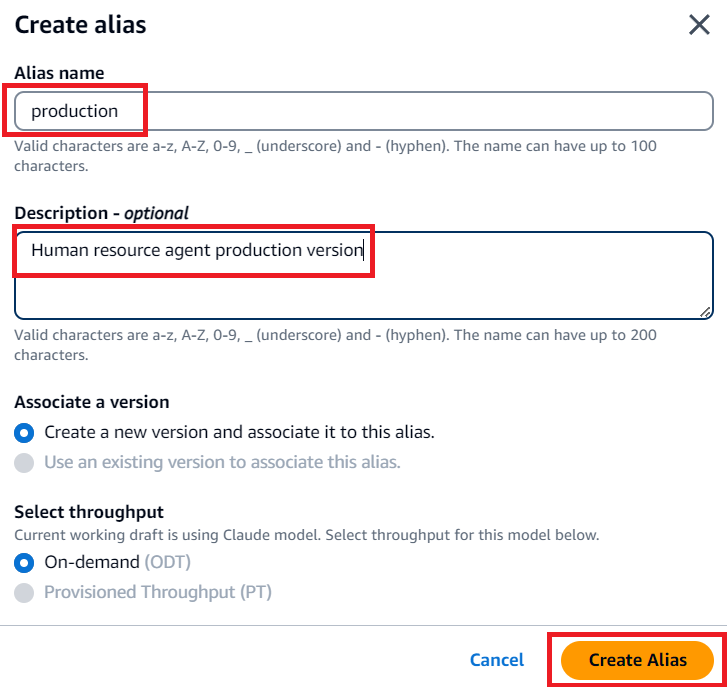

### **Step 3: Confirm alias is linked to correct agent version.**
- Each alias can point to a specific agent version.

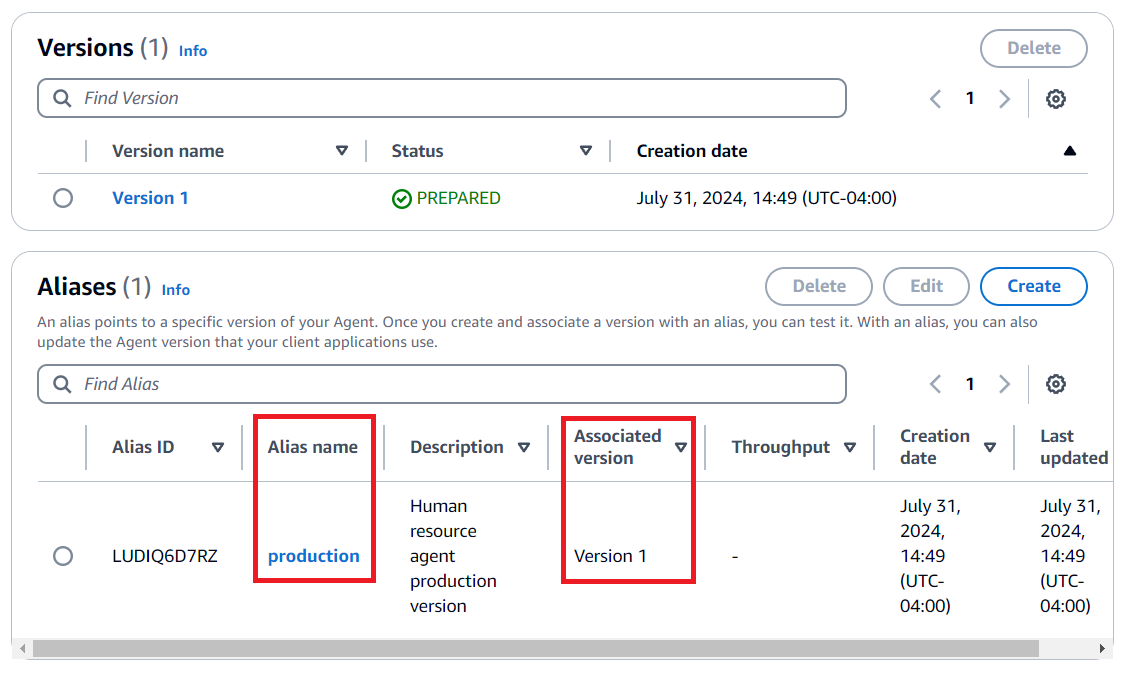

## **Agent versions and aliases**

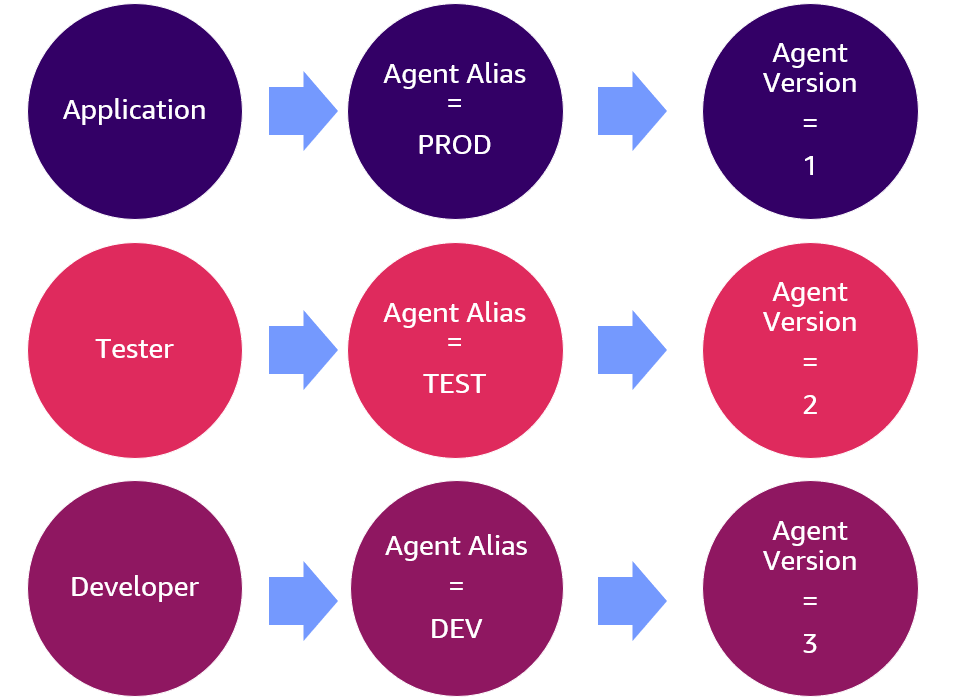

## Invoking an Agent

- Methods to Invoke an Agent
  - ✅ AWS Console
  - ✅ AWS SDKs (boto3, aws-sdk-js, etc.)
  - ❌ NOT Supported via CloudFormation, AWS CDK, Terraform (runtime operations).

### **Step 1: Install AWS SDK**
Ensure you have the latest AWS SDK installed:
>>pip install --upgrade -q boto3

>>pip install --upgrade -q botocore

>>pip install --upgrade -q awscli

### **Step 2: Create a Bedrock Runtime Client**

In [ ]:
import boto3

bedrock_agent_runtime_client = boto3.client('bedrock-agent-runtime')

### **Step 3: Invoke an Agent**

In [ ]:
agentResponse = bedrock_agent_runtime_client.invoke_agent(
    inputText="How much vacation does employee_id 1 have available?",
    agentId="<YOUR_AGENT_ID>",
    agentAliasId="TSTALIASID",
    sessionId="<SESSION_ID>"
)

- Required Parameters:

  - agentId: Unique ID of the agent.
  - agentAliasId: Alias ID (e.g., TSTALIASID).
  - sessionId: Unique session identifier.

## Additional agent functionality
### Trace functionality
- Trace Types:
  - 🟢 Pre-processing: Validates inputs.
  - 🔄 Orchestration: Runs actions or queries.
  - 📄 Post-processing: Formats output.
  - 🔒 Guardrail: Applies safety policies.
  - ❌ Failure: Logs errors.

- In the AWS Management Console, the trace capability is enabled by default.
- Each one of the traces (except Failure ) provides the ModelInvocationInput object.

In [ ]:
agentResponse = bedrock_agent_runtime_client.invoke_agent(
    inputText="Check vacation balance",
    agentId="<YOUR_AGENT_ID>",
    agentAliasId="TSTALIASID",
    sessionId="<SESSION_ID>",
    enableTrace=True
)

In [ ]:
# Agent orchestration step trace
#   ...
#   {
#     "agentAliasId": "TSTALIASID",
#     "agentId": "FBS6WKNXB0",
#     "agentVersion": "DRAFT",
#     "sessionId": "054405217165140",
#     "trace": {
#       "orchestrationTrace": {
#         "rationale": {
#           "text": "The user wants to book vacation time from 2025-01-16 to 
# 2025- 01-31.\n\n To book vacation time, I need to know the employee's ID. The user did not provide their employee ID in the question. I should ask for their employee ID before trying to book any vacation time.",
#           "traceId": "e3c82ace-6d82-4a92-991a-cb17632db905-0"
#         }
#       }
#     }
#   },
#   ...

### Session functionality
- Keeps conversation context for a session duration (max 1 hour).
- Use the same sessionId for continuity.

In [ ]:
session_id = "123"  # Keep the same session ID

# First API Call
agentResponse = bedrock_agent_runtime_client.invoke_agent(
    inputText="Check my vacation balance",
    agentId="<YOUR_AGENT_ID>",
    agentAliasId="TSTALIASID",
    sessionId=session_id
)

# Second API Call (same session)
agentResponse2 = bedrock_agent_runtime_client.invoke_agent(
    inputText="Book one day off for July 5th, 2025.",
    agentId="<YOUR_AGENT_ID>",
    agentAliasId="TSTALIASID",
    sessionId=session_id
)

### Memory functionality (currently in public preview)
- Allows persistent memory across sessions.
- Provide a memoryId to retain details from previous interactions.

In [ ]:
agentResponse = bedrock_agent_runtime_client.invoke_agent(
    inputText="Check my vacation balance",
    agentId="<YOUR_AGENT_ID>",
    agentAliasId="TSTALIASID",
    sessionId=session_id,
    memoryId="EMPLOYEE_123"
)

- Retrieve memory: GetAgentMemory
- Delete memory: DeleteAgentMemory

### Code interpretation functionality (currently in public preview)
- Enables on-the-fly code execution for data processing tasks.
- Attach files for AI-driven analysis.

In [ ]:
session_state = {
    "files": [ 
        {
            "name": "TestFile.csv", 
            "source": { 
                "sourceType": "S3", 
                "s3Location": {
                    "uri": "<File S3  URI>" 
                }
            },
            "useCase": "CHAT" 
        },
        {
            "name": "TestFile2.csv",
            "source": { 
                "sourceType": "BYTE_CONTENT", 
                "byteContent": {
                    "mediaType": "text/csv", 
                    "data": "<base64 encoded string>"
                }
            },
            "useCase": "CODE_INTERPRETER"
        }
    ]
} 

# invoke the agent API
agent_response = bedrock_agent_runtime_client.invoke_agent(
    inputText=query,
    agentId=agent_id,
    agentAliasId=alias_id,
    sessionId=session_id,
    enableTrace=(enable_trace | show_code_use), # Force tracing on if showing code use
    endSession=end_session,
    memoryId=memory_id,
    sessionState=session_state
)

### Using sessionAttributes and promptSessionAttributes
- Session Attributes: Stored throughout the session; information is not added to the prompt
- Prompt Session Attributes: Added only to the current request; information is added to the prompt

In [ ]:
def simple_agent_invoke(
        input_text, agent_id, agent_alias_id, session_id=None,
        enable_trace=False, end_session=False, session_state=dict()
):

    agentResponse = bedrock_agent_runtime_client.invoke_agent(
        inputText=input_text,
        agentId=agent_id,
        agentAliasId=agent_alias_id, 
        sessionId=session_id,
        enableTrace=enable_trace, 
        endSession= end_session,
        sessionState=session_state
    )
    
    event_stream = agentResponse['completion']
    try:
        for event in event_stream:        
            if 'chunk' in event:
                data = event['chunk']['bytes']
                return data.decode('utf8')
            elif 'trace' in event:
                logger.info(json.dumps(event['trace'], indent=2))
            else:
                raise Exception("unexpected event.", event)
    except Exception as e:
        raise Exception("unexpected event.", e)

from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')
print(today)

agent_id = "<your_agent_id>"
agent_alias_id = "TSTALIASID"
session_id:str = str(uuid.uuid1())
session_state = {
    "sessionAttributes": {
        "employee_id": "1"
    },
    "promptSessionAttributes": {
        "today": today
    }
}

agent_response_1 = simple_agent_invoke(
    "how many holidays do I have?", agent_id, agent_alias_id, 
    session_id, enable_trace=False, session_state=session_state
)
print(agent_response_1)

agent_response_2 = simple_agent_invoke(
    "great! book 2 days from next monday on.", agent_id, agent_alias_id, 
    session_id, enable_trace=False, session_state=session_state
)
print(agent_response_2)

- To retrieve session attributes in a Lambda function:

In [ ]:
def get_named_sessionAttribute(event, name):
    if name in event['sessionAttributes']:
        return event['sessionAttributes'][name]
    else:
        return None

def lambda_handler(event, context):
    employee_id = get_named_sessionAttribute(event, "employee_id")

## Key Takeaways
**Feature**	| **Description** <br>
Agent Alias | Maps to an immutable agent version for stable deployment. <br>
Agent Invocation | Supports console and SDK invocation with runtime capabilities. <br>
Trace | Enables step-by-step debugging for AI workflows. <br>
Session Management | Maintains conversation context within a session. <br>
Memory Retention | Remembers past conversations across sessions (preview). <br>
Code Interpretation | Runs AI-generated code for analytics (preview). <br>
Session Attributes | Passes dynamic context data to the agent.